In [1]:
import copy
import datetime
import warnings
warnings.filterwarnings(action='ignore') 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 시각화
import seaborn as sns
# 결측치
import missingno as msno

import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import model_selection, linear_model
from sklearn.metrics import auc

# 파이프라인
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 데이터 불러오기

In [2]:
data_df = pd.read_excel('2.all_data(전처리전_피쳐추출).xls')
data_df.head(3)

,고객번호,거주지,연령,가입경로,담당사원,상품코드,상담횟수,총구매횟수,총구매수량,총구매금액,총할인금액,최종결제금액,할인율,사용포인트,포인트사용여부,잔여포인트,재구매여부
0,11454,대구광역시,1979-06-15 00:00:00,M,박애신,89003,72,24.0,20,664200,184200,480000,28.0,0.0,0,96,0
1,14506,경기도,1986-09-11 00:00:00,M,전우영,89003,24,NaN,56,1771200,331200,1440000,19.0,120000.0,1,130,0
2,83078,충청남도,1111-11-11,M,박애신,89003,684,1044.0,420,15055200,3055200,12000000,20.0,0.0,0,96,0


# 데이터 탐색

In [3]:
## 주소, 나이, 담당직원, 총구매 횟수 결측치 존재 확인
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24801 entries, 0 to 24800
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   고객번호     24801 non-null  int64  
 1   거주지      24777 non-null  object 
 2   연령       22199 non-null  object 
 3   가입경로     24801 non-null  object 
 4   담당사원     24283 non-null  object 
 5   상품코드     24801 non-null  int64  
 6   상담횟수     24801 non-null  int64  
 7   총구매횟수    18155 non-null  float64
 8   총구매수량    24801 non-null  int64  
 9   총구매금액    24801 non-null  int64  
 10  총할인금액    24801 non-null  int64  
 11  최종결제금액   24801 non-null  int64  
 12  할인율      24799 non-null  float64
 13  사용포인트    24408 non-null  float64
 14  포인트사용여부  24801 non-null  int64  
 15  잔여포인트    24801 non-null  int64  
 16  재구매여부    24801 non-null  int64  
dtypes: float64(3), int64(10), object(4)
memory usage: 3.2+ MB


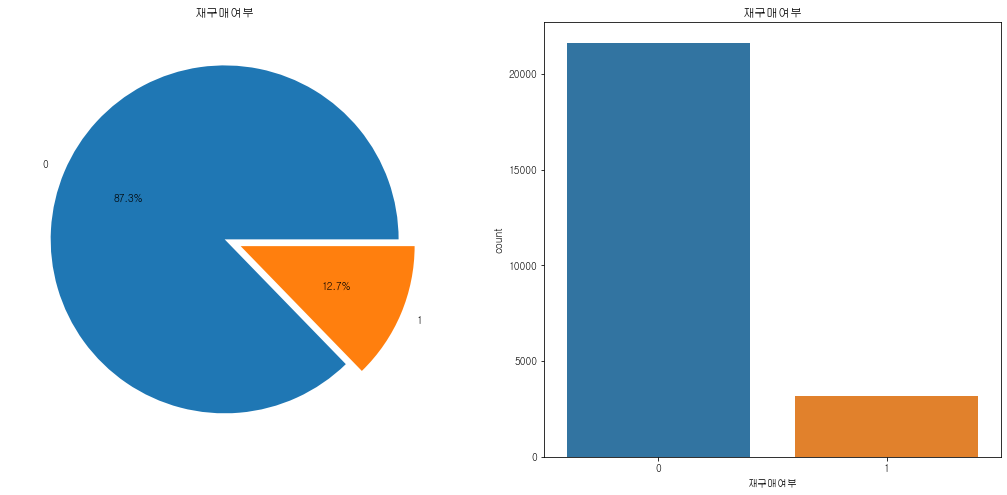

In [4]:
f, ax = plt.subplots(1,2,figsize=(18,8))
data_df['재구매여부'].value_counts()\
.plot.pie(explode = [0,0.1], autopct = '%1.1f%%', ax=ax[0])

ax[0].set_title('재구매여부')
ax[0].set_ylabel('')

sns.countplot('재구매여부', data = data_df, ax = ax[1])
ax[1].set_title('재구매여부')
plt.show()

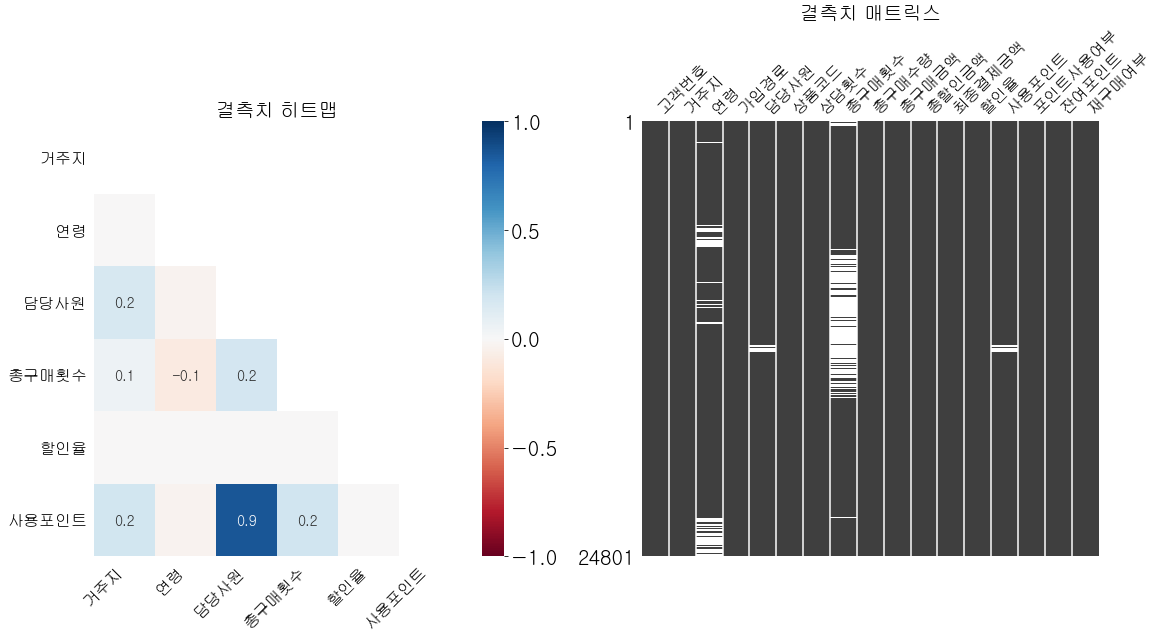

In [21]:
plt.rc('font', size=16)
f, ax = plt.subplots(1,2,figsize=(18,8))
msno.heatmap(data_df,ax=ax[0])
ax[0].set_title('결측치 히트맵')

msno.matrix(data_df,ax=ax[1])
ax[1].set_title('결측치 매트릭스')

plt.rc('font', size=20)        # 기본 폰트 크기
plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=50)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=50)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=30)  # 범례 폰트 크기
plt.rc('figure', titlesize=50) # figure title 폰트 크기

In [6]:
#범주형 컬럼 vaule_counts
print(data_df["거주지"].value_counts())
print("===================================")
print(data_df["담당사원"].value_counts())
print("===================================")

경기도        6949
서울특별시      3108
경상남도       1672
인천광역시      1593
부산광역시      1554
경상북도       1466
대구광역시      1354
충청남도       1157
충청북도        848
전라북도        819
전라남도        812
대전광역시       796
광주광역시       771
울산광역시       683
강원도         637
제주특별자치도     301
세종특별자치시     228
없음           29
Name: 거주지, dtype: int64
박애신      6225
전우영      5885
김필남      5129
정유경      3500
이선영      2294
마케팅1팀    1085
김영애        51
김연화        45
한나경        35
윤슬기        33
최고관리자       1
Name: 담당사원, dtype: int64


# 결측치 핸들링

## 주소(지역) 열 <br>
전체데이터 24325 행중 24행에 해당 전체데이터의 약 0.2퍼센트 해당 삭제 처리

In [7]:
data_df[data_df["거주지"] == "없음"].count()

고객번호       29
거주지        29
연령         29
가입경로       29
담당사원        0
상품코드       29
상담횟수       29
총구매횟수       0
총구매수량      29
총구매금액      29
총할인금액      29
최종결제금액     29
할인율        29
사용포인트       0
포인트사용여부    29
잔여포인트      29
재구매여부      29
dtype: int64

In [8]:
data_df[data_df["거주지"].isnull()].count()

고객번호       24
거주지         0
연령         23
가입경로       24
담당사원        5
상품코드       24
상담횟수       24
총구매횟수       0
총구매수량      24
총구매금액      24
총할인금액      24
최종결제금액     24
할인율        24
사용포인트       5
포인트사용여부    24
잔여포인트      24
재구매여부      24
dtype: int64

In [9]:
data_df_del_add = data_df[data_df["거주지"] != "없음"]

In [10]:
data_df_del_add = data_df_del_add[data_df_del_add["거주지"].notnull()]

In [11]:
data_df_del_add["거주지"].isnull().value_counts()

False    24748
Name: 거주지, dtype: int64

In [12]:
data_df_del_add[data_df_del_add["거주지"]=="없음"].count()

고객번호       0
거주지        0
연령         0
가입경로       0
담당사원       0
상품코드       0
상담횟수       0
총구매횟수      0
총구매수량      0
총구매금액      0
총할인금액      0
최종결제금액     0
할인율        0
사용포인트      0
포인트사용여부    0
잔여포인트      0
재구매여부      0
dtype: int64

In [13]:
data_df_del_add.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24748 entries, 0 to 24800
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   고객번호     24748 non-null  int64  
 1   거주지      24748 non-null  object 
 2   연령       22147 non-null  object 
 3   가입경로     24748 non-null  object 
 4   담당사원     24278 non-null  object 
 5   상품코드     24748 non-null  int64  
 6   상담횟수     24748 non-null  int64  
 7   총구매횟수    18155 non-null  float64
 8   총구매수량    24748 non-null  int64  
 9   총구매금액    24748 non-null  int64  
 10  총할인금액    24748 non-null  int64  
 11  최종결제금액   24748 non-null  int64  
 12  할인율      24746 non-null  float64
 13  사용포인트    24403 non-null  float64
 14  포인트사용여부  24748 non-null  int64  
 15  잔여포인트    24748 non-null  int64  
 16  재구매여부    24748 non-null  int64  
dtypes: float64(3), int64(10), object(4)
memory usage: 3.4+ MB


## 나이/생일 열<br>
현재 생년월일로 표현된 컬럼의 밸류를 나이형태로 교체하고, 결측치는 평균값으로 채워준다.<br>
나이의 범주가 연속값이므로 나이별 구간화 하여 범주형 카테고리로 변경한다.

### 나이/생일 열의 평균치 구하기

In [14]:
data_df_temp = data_df_del_add.copy()

In [15]:
#결측치 수 확인
data_df_temp["연령"].isnull().value_counts()

False    22147
True      2601
Name: 연령, dtype: int64

In [16]:
#나이/생일 열의 평균치를 구하기 위하여 결측,이상치를 제거한 임시 데이터 프래임을 생성한다.
data_df_birth = data_df_temp[data_df_temp["연령"].notnull()]
data_df_birth = data_df_birth[data_df_birth["연령"]!=0]
data_df_birth = data_df_birth[data_df_birth["연령"]!="0000-00-00"]
data_df_birth = data_df_birth[data_df_birth["연령"]!="1111-11-11"]
data_df_birth = data_df_birth[data_df_birth["연령"]!="1700-01-01"]

In [17]:
data_df_birth = data_df_birth.reset_index()
del data_df_birth["index"]
data_df_birth

,고객번호,거주지,연령,가입경로,담당사원,상품코드,상담횟수,총구매횟수,총구매수량,총구매금액,총할인금액,최종결제금액,할인율,사용포인트,포인트사용여부,잔여포인트,재구매여부
0,11454,대구광역시,1979-06-15 00:00:00,M,박애신,89003,72,24.0,20,664200,184200,480000,28.0,0.0,0,96,0
1,14506,경기도,1986-09-11 00:00:00,M,전우영,89003,24,NaN,56,1771200,331200,1440000,19.0,120000.0,1,130,0
2,141938,인천광역시,1983-03-06 00:00:00,E,전우영,89003,15,NaN,12,332100,152100,180000,46.0,0.0,0,130,0
3,145918,경기도,1984-06-06 00:00:00,H,박애신,89002,10,NaN,8,221400,101400,120000,46.0,0.0,0,96,0
4,154978,충청북도,1988-06-14 00:00:00,H,전우영,89001,32,NaN,92,2878200,598200,2280000,21.0,0.0,0,130,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21805,346758,경기도,2022-08-30 00:00:00,A,NaN,35023,1,0.0,0,18900,16400,2500,87.0,0.0,0,160,0
21806,346769,경상남도,2022-08-31 00:00:00,H,박애신,35025,1,1.0,1,18900,15900,3000,84.0,0.0,0,96,0
21807,346771,서울특별시,2022-08-31 00:00:00,H,박애신,35008,1,1.0,1,18900,13900,5000,74.0,0.0,0,96,0
21808,346776,전라남도,2022-08-31 00:00:00,H,박애신,35025,1,1.0,1,18900,15900,3000,84.0,0.0,0,96,0


In [18]:
data_df_birth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21810 entries, 0 to 21809
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   고객번호     21810 non-null  int64  
 1   거주지      21810 non-null  object 
 2   연령       21810 non-null  object 
 3   가입경로     21810 non-null  object 
 4   담당사원     21515 non-null  object 
 5   상품코드     21810 non-null  int64  
 6   상담횟수     21810 non-null  int64  
 7   총구매횟수    15922 non-null  float64
 8   총구매수량    21810 non-null  int64  
 9   총구매금액    21810 non-null  int64  
 10  총할인금액    21810 non-null  int64  
 11  최종결제금액   21810 non-null  int64  
 12  할인율      21808 non-null  float64
 13  사용포인트    21629 non-null  float64
 14  포인트사용여부  21810 non-null  int64  
 15  잔여포인트    21810 non-null  int64  
 16  재구매여부    21810 non-null  int64  
dtypes: float64(3), int64(10), object(4)
memory usage: 2.8+ MB


In [19]:
for i, row in data_df_birth.iterrows():
    if(type(row["연령"]) == str):
        pass
    else:
        birth_day = (int)(row["연령"].year)
        this_year = (int)(datetime.date.today().strftime("%Y"))

        age = (this_year - birth_day)+1

        row["연령"] = age
        data_df_birth.iloc[i] = row

In [20]:
#이상치 제거
data_df_birth = data_df_birth[data_df_birth["연령"] > 20]
data_df_birth = data_df_birth[data_df_birth["연령"] < 80]

In [21]:
#나이열 평균 35세로 확인
data_df_birth["연령"].mean()

35.23169164882227

### 나이/생일 열 나이 값으로 변환 전, 35세 해당 1988년으로 치환

In [22]:
data_df_temp = data_df_temp.reset_index()

del data_df_temp["index"]

data_df_temp

,고객번호,거주지,연령,가입경로,담당사원,상품코드,상담횟수,총구매횟수,총구매수량,총구매금액,총할인금액,최종결제금액,할인율,사용포인트,포인트사용여부,잔여포인트,재구매여부
0,11454,대구광역시,1979-06-15 00:00:00,M,박애신,89003,72,24.0,20,664200,184200,480000,28.0,0.0,0,96,0
1,14506,경기도,1986-09-11 00:00:00,M,전우영,89003,24,NaN,56,1771200,331200,1440000,19.0,120000.0,1,130,0
2,83078,충청남도,1111-11-11,M,박애신,89003,684,1044.0,420,15055200,3055200,12000000,20.0,0.0,0,96,0
3,141938,인천광역시,1983-03-06 00:00:00,E,전우영,89003,15,NaN,12,332100,152100,180000,46.0,0.0,0,130,0
4,145918,경기도,1984-06-06 00:00:00,H,박애신,89002,10,NaN,8,221400,101400,120000,46.0,0.0,0,96,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24743,346783,경상남도,NaN,H,이선영,35009,1,1.0,1,36900,27000,9900,73.0,0.0,0,161,0
24744,346784,부산광역시,2022-08-31 00:00:00,H,박애신,35008,4,2.0,7,240300,103300,137000,43.0,0.0,0,96,0
24745,346786,경상북도,NaN,H,전우영,35023,1,1.0,1,14000,11000,3000,79.0,0.0,0,130,0
24746,346787,경기도,NaN,E,전우영,35009,1,1.0,1,36900,27000,9900,73.0,0.0,0,130,0


In [23]:
for i, row in data_df_temp.iterrows():
    if(type(row["연령"]) == str or type(row["연령"]) == int or type(row["연령"]) == float):
        row["연령"] = datetime.datetime(1988,1,1)
        row["연령"] = row["연령"].year
    else:
        row["연령"] = row["연령"].year
        
    birth_day = row["연령"]
    this_year = (int)(datetime.date.today().strftime("%Y"))

    age = (this_year - birth_day)+1
    
    if (age < 20 or age > 80):
        row["연령"] = 35
    else:
        row["연령"] = age
        
        
    if row['연령']<=30 :
        row["연령"] = 1
    elif row['연령']<=40 :
        row["연령"] = 2
    elif row['연령']<=50 :
        row["연령"] = 3
    elif row['연령']<=60 :
        row["연령"] = 4
    elif row['연령']<=70 :
        row["연령"] = 5
    elif row['연령']<=80 :
        row["연령"] = 6
    
    data_df_temp.iloc[i] =  row

In [24]:
print(data_df_temp[data_df_temp["연령"] == "0"].count())
print("_____________________________________________________")
print(data_df_temp[data_df_temp["연령"]=="0000-00-00"].count())
print("_____________________________________________________")
print(data_df_temp[data_df_temp["연령"]=="1111-11-11"].count())
print("_____________________________________________________")
print(data_df_temp[data_df_temp["연령"]=="1700-01-01"].count())
print("_____________________________________________________")
print(data_df_temp[data_df_temp["연령"].isnull()].count())

고객번호       0
거주지        0
연령         0
가입경로       0
담당사원       0
상품코드       0
상담횟수       0
총구매횟수      0
총구매수량      0
총구매금액      0
총할인금액      0
최종결제금액     0
할인율        0
사용포인트      0
포인트사용여부    0
잔여포인트      0
재구매여부      0
dtype: int64
_____________________________________________________
고객번호       0
거주지        0
연령         0
가입경로       0
담당사원       0
상품코드       0
상담횟수       0
총구매횟수      0
총구매수량      0
총구매금액      0
총할인금액      0
최종결제금액     0
할인율        0
사용포인트      0
포인트사용여부    0
잔여포인트      0
재구매여부      0
dtype: int64
_____________________________________________________
고객번호       0
거주지        0
연령         0
가입경로       0
담당사원       0
상품코드       0
상담횟수       0
총구매횟수      0
총구매수량      0
총구매금액      0
총할인금액      0
최종결제금액     0
할인율        0
사용포인트      0
포인트사용여부    0
잔여포인트      0
재구매여부      0
dtype: int64
_____________________________________________________
고객번호       0
거주지        0
연령         0
가입경로       0
담당사원       0
상품코드       0
상담횟수       0
총구매횟수      0
총구매수량      0
총구매금액      0
총할인금액 

In [25]:
data_df_temp['연령'].value_counts()
data_df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24748 entries, 0 to 24747
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   고객번호     24748 non-null  int64  
 1   거주지      24748 non-null  object 
 2   연령       24748 non-null  object 
 3   가입경로     24748 non-null  object 
 4   담당사원     24278 non-null  object 
 5   상품코드     24748 non-null  int64  
 6   상담횟수     24748 non-null  int64  
 7   총구매횟수    18155 non-null  float64
 8   총구매수량    24748 non-null  int64  
 9   총구매금액    24748 non-null  int64  
 10  총할인금액    24748 non-null  int64  
 11  최종결제금액   24748 non-null  int64  
 12  할인율      24746 non-null  float64
 13  사용포인트    24403 non-null  float64
 14  포인트사용여부  24748 non-null  int64  
 15  잔여포인트    24748 non-null  int64  
 16  재구매여부    24748 non-null  int64  
dtypes: float64(3), int64(10), object(4)
memory usage: 3.2+ MB


In [26]:
data_df_add_age = data_df_temp.copy()

## TM담당직원 열 결측치 처리<br>
전체 데이터의 512행에 해당하는 데이터 null값 확인 약 2.4퍼센트행에 대한 최빈 값으로 대체

In [27]:
data_df_temp["담당사원"].value_counts()

박애신      6225
전우영      5881
김필남      5128
정유경      3500
이선영      2294
마케팅1팀    1085
김영애        51
김연화        45
한나경        35
윤슬기        33
최고관리자       1
Name: 담당사원, dtype: int64

In [28]:
data_df_temp["담당사원"].isnull().value_counts()

False    24278
True       470
Name: 담당사원, dtype: int64

In [29]:
data_df_temp.loc[data_df_temp["담당사원"].isnull()==True, "담당사원" ] = "박애신"
data_df_temp["담당사원"].isnull().value_counts()

False    24748
Name: 담당사원, dtype: int64

In [30]:
data_df_add_age_tm = data_df_temp.copy()

## 총구매 횟수 열 결측치 평균값으로 대체

In [31]:
data_df_temp["총구매횟수"].isnull().value_counts()

False    18155
True      6593
Name: 총구매횟수, dtype: int64

In [32]:
data_df_temp.loc[data_df_temp["총구매횟수"].isnull()==True, "총구매횟수" ] = data_df_temp["총구매횟수"].mean()
data_df_temp["총구매횟수"].isnull().value_counts()

False    24748
Name: 총구매횟수, dtype: int64

In [33]:
data_df_temp["총구매횟수"].mean()

19.775268521063186

In [34]:
data_df_add_age_tm_totalCnt = data_df_temp.copy()

In [35]:
data_df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24748 entries, 0 to 24747
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   고객번호     24748 non-null  int64  
 1   거주지      24748 non-null  object 
 2   연령       24748 non-null  object 
 3   가입경로     24748 non-null  object 
 4   담당사원     24748 non-null  object 
 5   상품코드     24748 non-null  int64  
 6   상담횟수     24748 non-null  int64  
 7   총구매횟수    24748 non-null  float64
 8   총구매수량    24748 non-null  int64  
 9   총구매금액    24748 non-null  int64  
 10  총할인금액    24748 non-null  int64  
 11  최종결제금액   24748 non-null  int64  
 12  할인율      24746 non-null  float64
 13  사용포인트    24403 non-null  float64
 14  포인트사용여부  24748 non-null  int64  
 15  잔여포인트    24748 non-null  int64  
 16  재구매여부    24748 non-null  int64  
dtypes: float64(3), int64(10), object(4)
memory usage: 3.2+ MB


## 할인율 열 결측치 평균값 대체

In [36]:
data_df_temp['할인율'].value_counts()

 84.0     5063
 100.0    4010
 74.0     3148
 79.0     1390
 86.0      644
          ... 
 68.0        1
-12.0        1
 398.0       1
 299.0       1
-2.0         1
Name: 할인율, Length: 101, dtype: int64

In [37]:
# 마이너스 삭제
data_df_temp = data_df_temp[data_df_temp['할인율'] > 0]

In [38]:
# 100프로를 넘는값 삭제
data_df_temp = data_df_temp[data_df_temp['할인율'] < 100]
data_df_temp

,고객번호,거주지,연령,가입경로,담당사원,상품코드,상담횟수,총구매횟수,총구매수량,총구매금액,총할인금액,최종결제금액,할인율,사용포인트,포인트사용여부,잔여포인트,재구매여부
0,11454,대구광역시,3,M,박애신,89003,72,24.000000,20,664200,184200,480000,28.0,0.0,0,96,0
1,14506,경기도,2,M,전우영,89003,24,19.775269,56,1771200,331200,1440000,19.0,120000.0,1,130,0
2,83078,충청남도,2,M,박애신,89003,684,1044.000000,420,15055200,3055200,12000000,20.0,0.0,0,96,0
3,141938,인천광역시,2,E,전우영,89003,15,19.775269,12,332100,152100,180000,46.0,0.0,0,130,0
4,145918,경기도,2,H,박애신,89002,10,19.775269,8,221400,101400,120000,46.0,0.0,0,96,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24742,346780,부산광역시,2,H,정유경,35009,1,1.000000,1,36900,27000,9900,73.0,0.0,0,160,0
24743,346783,경상남도,2,H,이선영,35009,1,1.000000,1,36900,27000,9900,73.0,0.0,0,161,0
24744,346784,부산광역시,2,H,박애신,35008,4,2.000000,7,240300,103300,137000,43.0,0.0,0,96,0
24745,346786,경상북도,2,H,전우영,35023,1,1.000000,1,14000,11000,3000,79.0,0.0,0,130,0


In [39]:
data_df_temp['할인율'].value_counts()

84.0    5063
74.0    3148
79.0    1390
86.0     644
49.0     551
        ... 
65.0       2
68.0       1
95.0       1
67.0       1
3.0        1
Name: 할인율, Length: 91, dtype: int64

## 사용포인트 컬럼 삭제

In [40]:
del data_df_temp['사용포인트']

## 상품코드 이상치 삭제

In [41]:
data_df_temp['상품코드'].value_counts().tail(10)

4004     1
78011    1
6003     1
16002    1
56002    1
12001    1
48001    1
52001    1
19002    1
35001    1
Name: 상품코드, dtype: int64

In [42]:
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=35001]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=38004]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=90002]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=83001]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=90012]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=90007]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=90004]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=35030]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=73001]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=72010]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=39002]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=38003]

data_df_temp = data_df_temp[data_df_temp["상품코드"]!=90013]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=90006]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=90005]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=90011]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=73002]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=38001]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=38002]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=72001]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=90001]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=72012]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=37001]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=90014]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=72002]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=35021]

data_df_temp = data_df_temp[data_df_temp["상품코드"]!=35028]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=35086]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=12004]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=56001]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=52007]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=18001]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=39001]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=6001]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=19002]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=48001]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=52001]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=12001]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=56002]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=16002]

data_df_temp = data_df_temp[data_df_temp["상품코드"]!=6003]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=4004]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=69004]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=78011]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=19001]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=12012]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=37002]

data_df_temp = data_df_temp[data_df_temp["상품코드"]!=35027]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=12009]
data_df_temp = data_df_temp[data_df_temp["상품코드"]!=35029]

In [43]:
data_df_temp['상품코드'].value_counts().tail(30)

35025    1009
35026     484
35033     383
36002     347
36001     303
35005     245
71011     227
35032     182
71001     174
35006     169
89003     169
71012     136
35035     128
71003     117
36003     112
71002     110
90009     107
35034      89
90010      89
37003      85
27001      84
35031      76
36004      67
71013      61
90008      55
89001      54
89002      49
35011      44
35022      39
72011      25
Name: 상품코드, dtype: int64

Text(0.5, 1.0, '결측치 매트릭스')

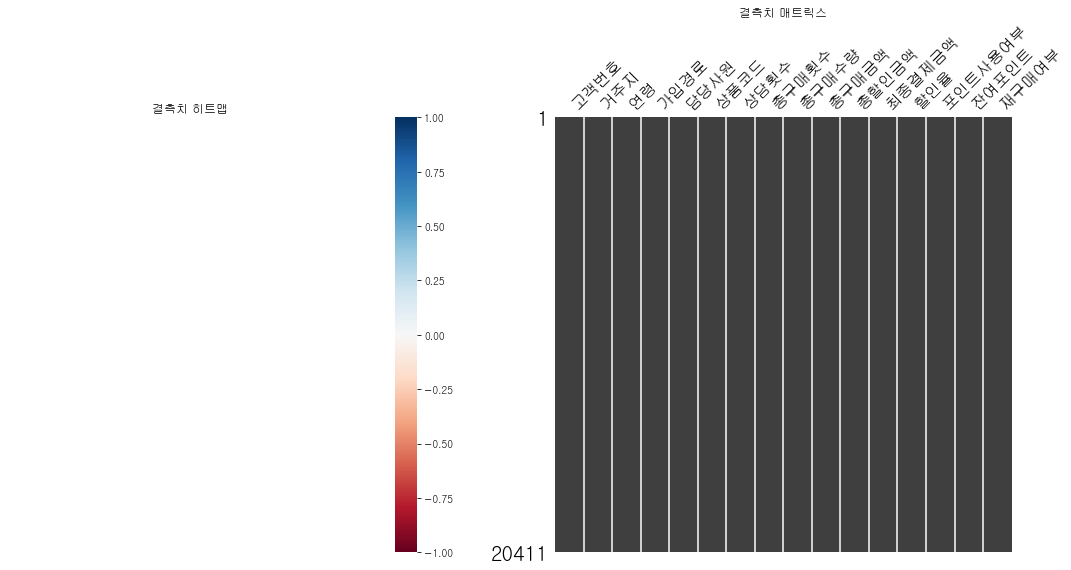

In [44]:
f, ax = plt.subplots(1,2,figsize=(18,8))
msno.heatmap(data_df_temp,ax=ax[0])
ax[0].set_title('결측치 히트맵')

msno.matrix(data_df_temp,ax=ax[1])
ax[1].set_title('결측치 매트릭스')

In [45]:
data_df_temp.reset_index(inplace=True)

In [46]:
#data_df_temp.to_excel('1231.xlsx')

# 학습데이터 와 타겟데이터 분리

In [47]:
y_data=data_df_temp[["재구매여부"]].copy()
x_data=data_df_temp.copy()
del x_data["재구매여부"]
del x_data["고객번호"]

In [48]:
y_data

,재구매여부
0,0
1,0
2,0
3,0
4,0
...,...
20406,0
20407,0
20408,0
20409,0


In [49]:
x_data

,index,거주지,연령,가입경로,담당사원,상품코드,상담횟수,총구매횟수,총구매수량,총구매금액,총할인금액,최종결제금액,할인율,포인트사용여부,잔여포인트
0,0,대구광역시,3,M,박애신,89003,72,24.000000,20,664200,184200,480000,28.0,0,96
1,1,경기도,2,M,전우영,89003,24,19.775269,56,1771200,331200,1440000,19.0,1,130
2,2,충청남도,2,M,박애신,89003,684,1044.000000,420,15055200,3055200,12000000,20.0,0,96
3,3,인천광역시,2,E,전우영,89003,15,19.775269,12,332100,152100,180000,46.0,0,130
4,4,경기도,2,H,박애신,89002,10,19.775269,8,221400,101400,120000,46.0,0,96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20406,24742,부산광역시,2,H,정유경,35009,1,1.000000,1,36900,27000,9900,73.0,0,160
20407,24743,경상남도,2,H,이선영,35009,1,1.000000,1,36900,27000,9900,73.0,0,161
20408,24744,부산광역시,2,H,박애신,35008,4,2.000000,7,240300,103300,137000,43.0,0,96
20409,24745,경상북도,2,H,전우영,35023,1,1.000000,1,14000,11000,3000,79.0,0,130


# Data Scaling

## 범주형컬럼 one-hot encoding

In [50]:
x_data_categorical = x_data[["거주지","연령","가입경로","담당사원","상품코드","포인트사용여부"]]

In [51]:
x_data_categorical

,거주지,연령,가입경로,담당사원,상품코드,포인트사용여부
0,대구광역시,3,M,박애신,89003,0
1,경기도,2,M,전우영,89003,1
2,충청남도,2,M,박애신,89003,0
3,인천광역시,2,E,전우영,89003,0
4,경기도,2,H,박애신,89002,0
...,...,...,...,...,...,...
20406,부산광역시,2,H,정유경,35009,0
20407,경상남도,2,H,이선영,35009,0
20408,부산광역시,2,H,박애신,35008,0
20409,경상북도,2,H,전우영,35023,0


In [52]:
encoder = OneHotEncoder(sparse=False)

x_data_categorical = pd.DataFrame(encoder.fit_transform(x_data_categorical[["거주지","연령","가입경로","담당사원","상품코드","포인트사용여부"]]))

x_data_categorical.columns = encoder.get_feature_names(["거주지","연령","가입경로","담당사원","상품코드","포인트사용여부"])

In [53]:
x_data_categorical

,거주지_강원도,거주지_경기도,거주지_경상남도,거주지_경상북도,거주지_광주광역시,거주지_대구광역시,거주지_대전광역시,거주지_부산광역시,거주지_서울특별시,거주지_세종특별자치시,...,상품코드_71013,상품코드_72011,상품코드_89001,상품코드_89002,상품코드_89003,상품코드_90008,상품코드_90009,상품코드_90010,포인트사용여부_0,포인트사용여부_1
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
20407,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
20408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
20409,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [54]:
x_data.drop(["거주지","연령","가입경로","담당사원","상품코드","포인트사용여부"], axis=1, inplace=True)

In [55]:
x_data

,index,상담횟수,총구매횟수,총구매수량,총구매금액,총할인금액,최종결제금액,할인율,잔여포인트
0,0,72,24.000000,20,664200,184200,480000,28.0,96
1,1,24,19.775269,56,1771200,331200,1440000,19.0,130
2,2,684,1044.000000,420,15055200,3055200,12000000,20.0,96
3,3,15,19.775269,12,332100,152100,180000,46.0,130
4,4,10,19.775269,8,221400,101400,120000,46.0,96
...,...,...,...,...,...,...,...,...,...
20406,24742,1,1.000000,1,36900,27000,9900,73.0,160
20407,24743,1,1.000000,1,36900,27000,9900,73.0,161
20408,24744,4,2.000000,7,240300,103300,137000,43.0,96
20409,24745,1,1.000000,1,14000,11000,3000,79.0,130


In [56]:
x_data = pd.concat([x_data, x_data_categorical],axis=1)
x_data

,index,상담횟수,총구매횟수,총구매수량,총구매금액,총할인금액,최종결제금액,할인율,잔여포인트,거주지_강원도,...,상품코드_71013,상품코드_72011,상품코드_89001,상품코드_89002,상품코드_89003,상품코드_90008,상품코드_90009,상품코드_90010,포인트사용여부_0,포인트사용여부_1
0,0,72,24.000000,20,664200,184200,480000,28.0,96,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1,24,19.775269,56,1771200,331200,1440000,19.0,130,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,2,684,1044.000000,420,15055200,3055200,12000000,20.0,96,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,3,15,19.775269,12,332100,152100,180000,46.0,130,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,4,10,19.775269,8,221400,101400,120000,46.0,96,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20406,24742,1,1.000000,1,36900,27000,9900,73.0,160,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
20407,24743,1,1.000000,1,36900,27000,9900,73.0,161,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
20408,24744,4,2.000000,7,240300,103300,137000,43.0,96,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
20409,24745,1,1.000000,1,14000,11000,3000,79.0,130,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## 연속형 컬럼 Standardization

In [57]:
x_data_num = x_data[['상담횟수','총구매횟수', '총구매수량','총구매금액','총할인금액','최종결제금액','할인율','잔여포인트']]

In [58]:
std_scaler=StandardScaler()
x_data_num = pd.DataFrame(std_scaler.fit_transform(x_data_num[['상담횟수','총구매횟수', '총구매수량','총구매금액','총할인금액','최종결제금액','할인율','잔여포인트']]))
x_data[['상담횟수','총구매횟수', '총구매수량','총구매금액','총할인금액','최종결제금액','할인율','잔여포인트']] =x_data_num
x_data

,index,상담횟수,총구매횟수,총구매수량,총구매금액,총할인금액,최종결제금액,할인율,잔여포인트,거주지_강원도,...,상품코드_71013,상품코드_72011,상품코드_89001,상품코드_89002,상품코드_89003,상품코드_90008,상품코드_90009,상품코드_90010,포인트사용여부_0,포인트사용여부_1
0,0,0.342886,0.010505,0.211099,0.286519,0.337180,0.267413,-1.149961,-0.022738,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1,-0.066448,-0.040536,1.444408,1.504277,1.039831,1.619112,-1.497083,0.603617,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,2,5.561898,12.333555,13.914533,16.117377,14.060375,16.487803,-1.458514,-0.022738,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,3,-0.143199,-0.040536,-0.062970,-0.078809,0.183744,-0.154993,-0.455717,0.603617,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,4,-0.185838,-0.040536,-0.200004,-0.200585,-0.058598,-0.239474,-0.455717,-0.022738,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20406,24742,-0.262588,-0.267368,-0.439814,-0.403544,-0.414226,-0.394497,0.585649,1.156284,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
20407,24743,-0.262588,-0.267368,-0.439814,-0.403544,-0.414226,-0.394497,0.585649,1.174706,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
20408,24744,-0.237004,-0.255287,-0.234263,-0.179794,-0.049516,-0.215538,-0.571424,-0.022738,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
20409,24745,-0.262588,-0.267368,-0.439814,-0.428736,-0.490705,-0.404212,0.817064,0.603617,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


<AxesSubplot:>

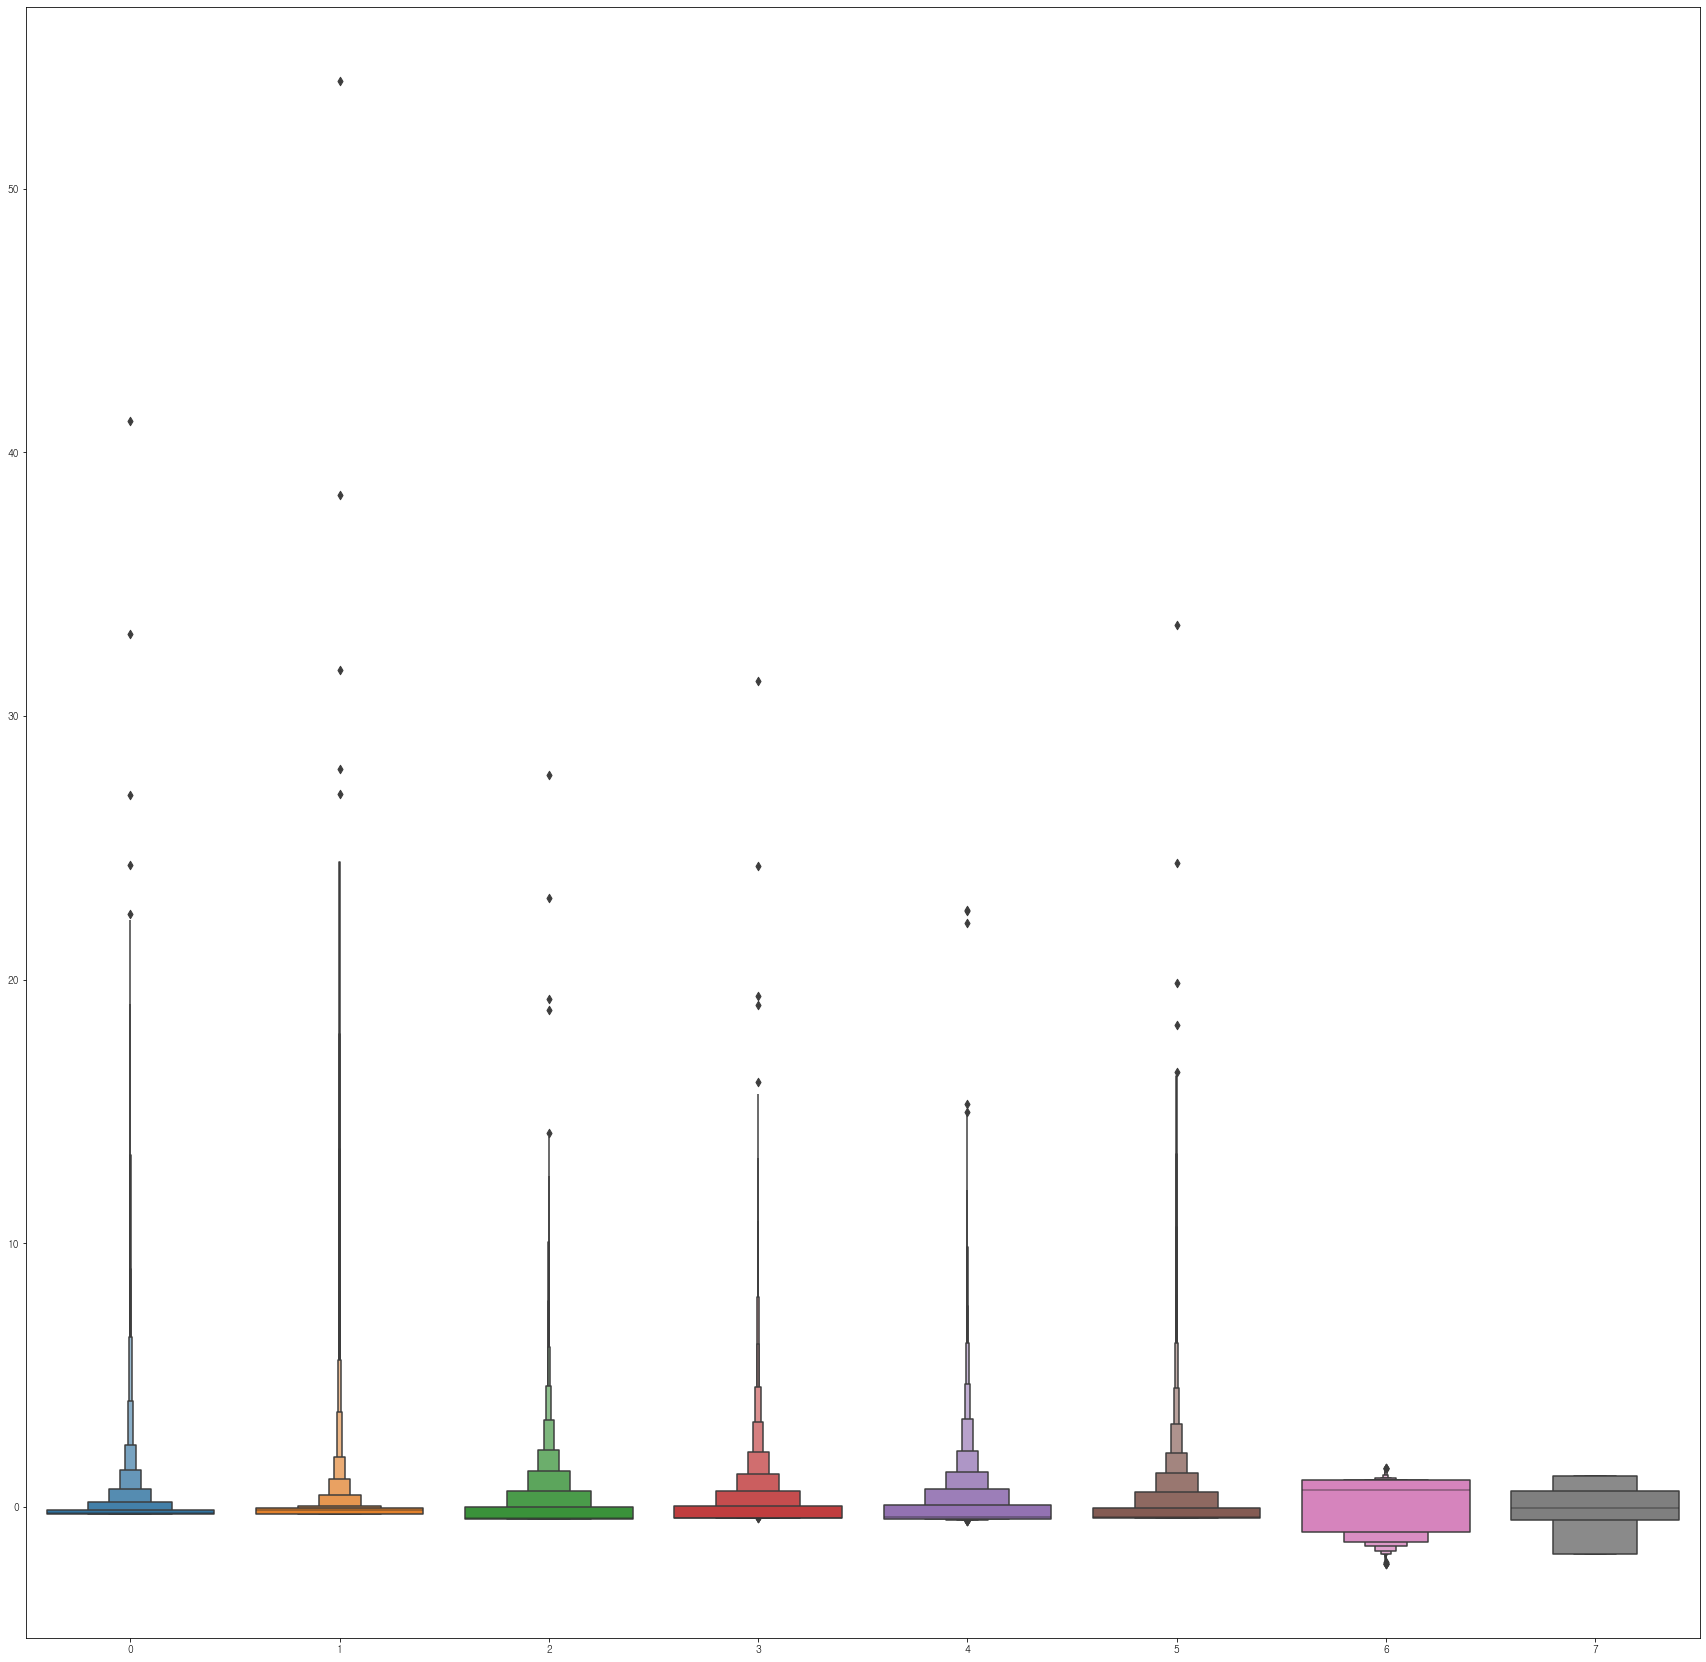

In [59]:
plt.figure(figsize=(30,30))
sns.boxenplot(data=x_data_num)

# Train - Test split (비율 7:3 , seed는 0을 적용)

In [60]:
x_train, x_test, y_train, y_test =\
model_selection.train_test_split(x_data, y_data, test_size=0.3, random_state=0)

# Train the model

In [61]:
from sklearn import ensemble
from sklearn.metrics import accuracy_score

In [62]:
# params = {'n_estimators': 100,
#           'max_depth': 4,
#           'min_samples_split': 5,           
# #          'learning_rate': 0.01,
#           'random_state':0}

# 앙상블 기본 모델 학습 및 정확도 측정 

In [63]:
clf_RFC = ensemble.RandomForestClassifier()
clf_RFC.fit(x_train, y_train)
acc = accuracy_score(y_test, clf_RFC.predict(x_test))
print("The accuracy score on test set: {:.4f}".format(acc))

The accuracy score on test set: 0.8859


In [64]:
clf_DTC = sklearn.tree.DecisionTreeClassifier(random_state=0)
clf_DTC.fit(x_train, y_train)
acc = accuracy_score(y_test, clf_DTC.predict(x_test))
print("The accuracy score on test set: {:.4f}".format(acc))

The accuracy score on test set: 0.8697


# 부스팅 알고리즘 학습 및 정확도 측정

In [65]:
from xgboost import XGBClassifier

In [66]:
clf_XGB = XGBClassifier(random_state=0)
clf_XGB.fit(x_train, y_train)
acc = accuracy_score(y_test, clf_XGB.predict(x_test))
print("The accuracy score on test set: {:.4f}".format(acc))

The accuracy score on test set: 0.8841


In [67]:
clf_GB = ensemble.GradientBoostingClassifier()
clf_GB.fit(x_train, y_train)
acc = accuracy_score(y_test, clf_GB.predict(x_test))
print("The accuracy score on test set: {:.4f}".format(acc))

The accuracy score on test set: 0.8863


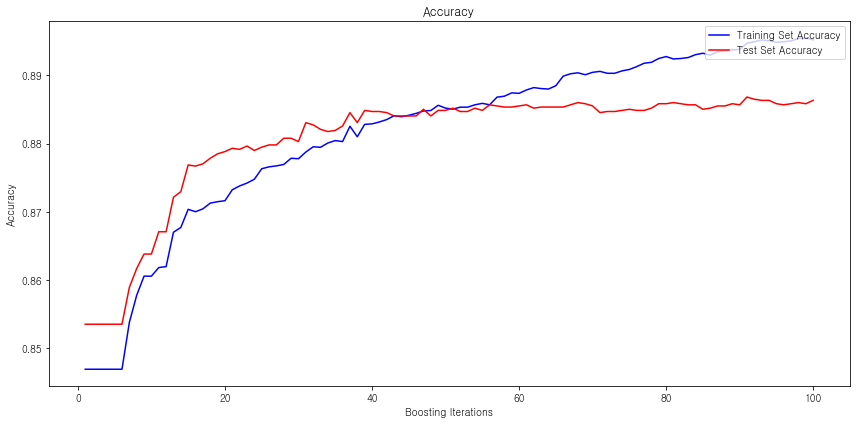

In [80]:
train_score = np.zeros((clf_GB.n_estimators,), dtype=np.float64)
for i, y_pred in enumerate(clf_GB.staged_predict(x_train)):
    train_score[i] = accuracy_score(y_train, y_pred)

test_score = np.zeros((clf_GB.n_estimators,), dtype=np.float64)
for i, y_pred in enumerate(clf_GB.staged_predict(x_test)):
    test_score[i] = accuracy_score(y_test, y_pred)
    
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1)
plt.title('Accuracy') # Binomial deviance loss function for binary classification
plt.plot(np.arange(clf_GB.n_estimators) + 1, train_score, 'b-', label='Training Set Accuracy')
plt.plot(np.arange(clf_GB.n_estimators) + 1, test_score, 'r-', label='Test Set Accuracy')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Accuracy')
fig.tight_layout()
plt.show()

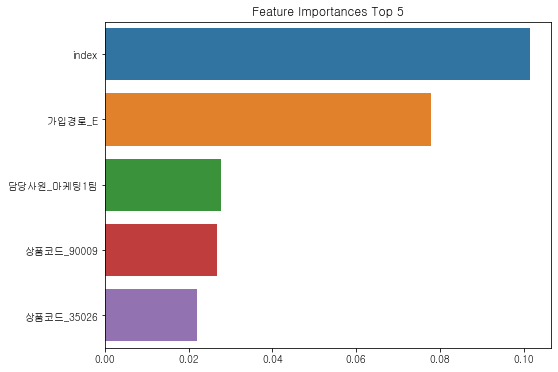

In [69]:
import seaborn as sns

feature_importance_values = clf_XGB.feature_importances_
# Top 중요도로 정렬하고, 쉽게 시각화하기 위해 Series 변환
feature_importances = pd.Series(feature_importance_values, index=x_train.columns)
# 중요도값 순으로 Series를 정렬
feature_top5 = feature_importances.sort_values(ascending=False)[:5]

plt.figure(figsize=[8, 6])
plt.title('Feature Importances Top 5')
sns.barplot(x=feature_top5, y=feature_top5.index)
plt.show()

In [70]:
# x_data.to_excel("./x_data.xlsx")
# y_data.to_excel("./y_data.xlsx")

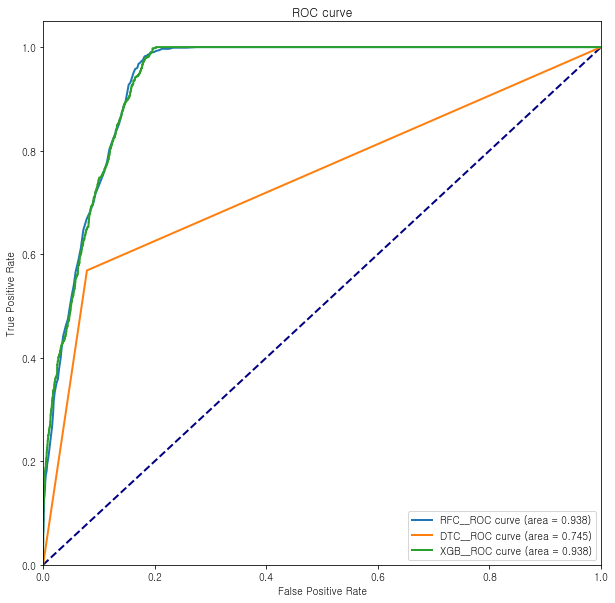

In [71]:
from sklearn.metrics import roc_curve, auc

models=['RFC', 'DTC', 'XGB']


plt.figure(figsize=(10, 10))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title("ROC curve")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')


# Global 변수 (전역 변수)
# string으로 변수를 설정하고, 값을 할당의 목적으로 사용

for i in models:

    globals()['clf_{}_pred'.format(i)] = \
    globals()['clf_{}'.format(i)].predict_proba(x_test)
    
    globals()['clf_{}_roc'.format(i)]=\
    globals()['clf_{}_pred'.format(i)][:,1]
   
    globals()['fpr_{}'.format(i)],\
    globals()['tpr_{}'.format(i)], \
    globals()['_{}'.format(i)] \
    =roc_curve(y_true=y_test, y_score=globals()['clf_{}_roc'.format(i)]) 
    
    globals()['roc_auc_{}'.format(i)] = \
    auc(globals()['fpr_{}'.format(i)], globals()['tpr_{}'.format(i)])
    
    
    
    plt.plot(globals()['fpr_{}'.format(i)], globals()['tpr_{}'.format(i)]
             , lw=2, label=i+'__ROC curve (area = %0.3f)' %globals()['roc_auc_{}'.format(i)])


# # Stack model은 S_test data로 진행하므로 따로 정리함.
# clf_STACK_pred = clf_STACK_predict_proba(S_test)
# clf_STACK_roc = clf_STACK_pred[:,1]
# fpr_STACK, tpr_STACK, _STACK = roc_curve(y_true = y_test, y_score = clf_STACK_roc)
# roc_auc_STACK = auc(fpr_STACK, tpr_STACK)
# plt.plot(fpr_STACK, tpr_STACK, lw=2, label='STACK curve (area = %0.2f)'\
#          % roc_auc_STACK)


plt.legend()
plt.show()

In [72]:
from sklearn.metrics import classification_report

predictions = clf_XGB.predict(x_test)
print(classification_report(y_test, predictions)) # Precision, Recall, F1-score 등을 확인할 수 있습니다.

print("Accuracy on Training set: {:.3f}".format(clf_XGB.score(x_train, y_train)))
print("Accuracy on Test set: {:.3f}".format(clf_XGB.score(x_test, y_test)))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      5227
           1       0.61      0.57      0.59       897

    accuracy                           0.88      6124
   macro avg       0.77      0.76      0.76      6124
weighted avg       0.88      0.88      0.88      6124

Accuracy on Training set: 0.971
Accuracy on Test set: 0.884


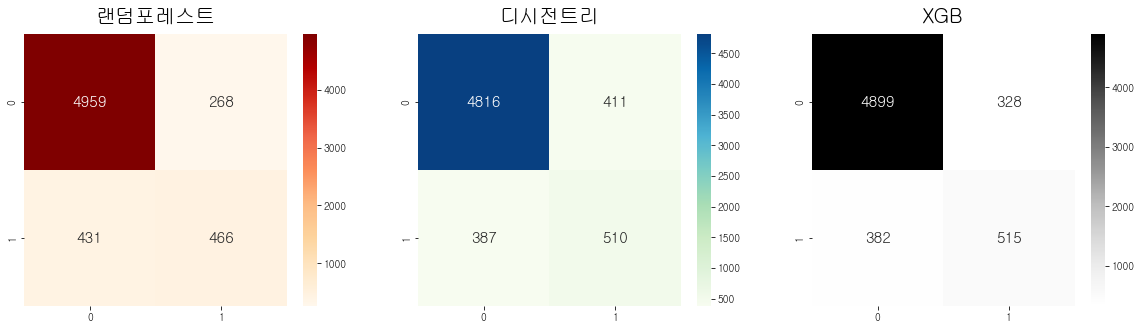

In [73]:
# confusion matrix
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 5))

confu = confusion_matrix(y_true = y_test, y_pred = clf_RFC.predict(x_test))
confu2 = confusion_matrix(y_true = y_test, y_pred = clf_DTC.predict(x_test))
confu3 = confusion_matrix(y_true = y_test, y_pred = clf_XGB.predict(x_test))


sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g', ax=ax[0])
sns.heatmap(confu2, annot=True, annot_kws={'size':15}, cmap='GnBu', fmt='.10g', ax=ax[1])
sns.heatmap(confu3, annot=True, annot_kws={'size':15}, cmap='Greys', fmt='.10g', ax=ax[2])
ax[0].set_title('랜덤포레스트',pad = 12, fontsize = 20)
ax[1].set_title('디시전트리',pad = 12, fontsize = 20)
ax[2].set_title('XGB',pad = 12, fontsize = 20)
plt.show()

Text(0.5, 1.0, '결측치 매트릭스')

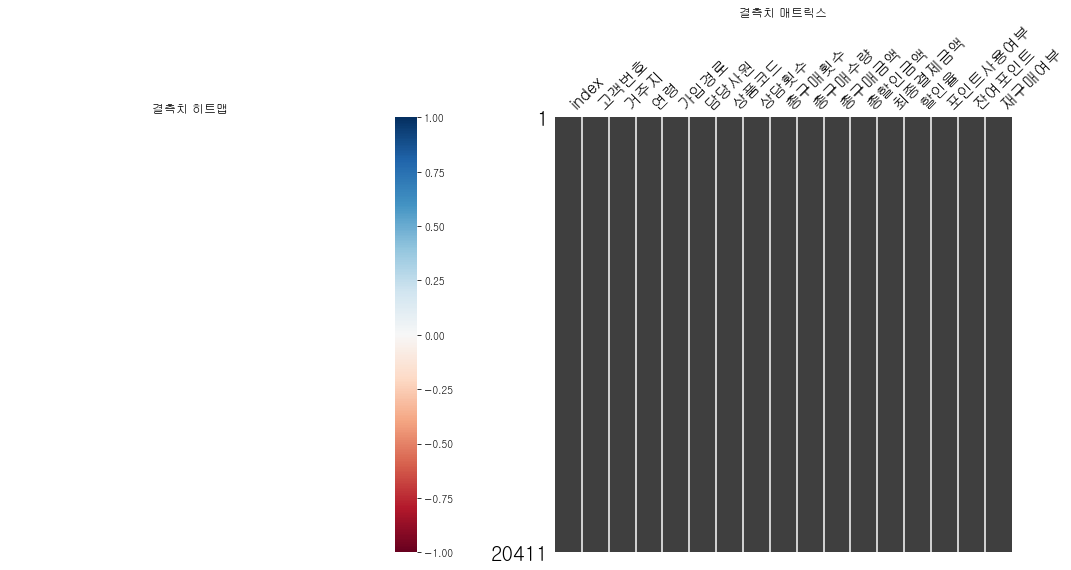

In [74]:
f, ax = plt.subplots(1,2,figsize=(18,8))
msno.heatmap(data_df_temp,ax=ax[0])
ax[0].set_title('결측치 히트맵')

msno.matrix(data_df_temp,ax=ax[1])
ax[1].set_title('결측치 매트릭스')